In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,RobustScaler,StandardScaler,OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.callbacks import EarlyStopping
import joblib
import matplotlib.pyplot as plt

In [2]:
# Load the dataset
df = pd.read_csv('/home/suhas/Desktop/office/Data Science/Notes/Data Analysis/Data/HR-Employee-Attrition.csv')

In [23]:
df.shape

(1470, 35)

In [24]:
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [3]:
# Define significant numerical and categorical features
updated_num = ['Age', 'DailyRate', 'DistanceFromHome', 'EnvironmentSatisfaction', 
               'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 
               'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 
               'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 
               'YearsWithCurrManager']
updated_cat = ['BusinessTravel', 'Department', 'EducationField', 'JobRole', 
               'MaritalStatus', 'OverTime']

In [4]:
# Select features (X) and target (y)
X = df[updated_num + updated_cat]
y = df['Attrition']

In [5]:
# Encode the target variable ('Yes' -> 1, 'No' -> 0)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [6]:
# Define preprocessing pipelines
# Numerical pipeline: impute missing values, apply robust scaling, then standard scaling
num_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('robust', RobustScaler()),
    ('scaler', StandardScaler())
])

# Categorical pipeline: impute missing values, one-hot encode with drop='first'
cat_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(drop='first', sparse=False))
])

# Combine pipelines into a ColumnTransformer
preprocessor = ColumnTransformer([
    ('num_pipe', num_pipeline, updated_num),
    ('cat_pipe', cat_pipeline, updated_cat)
])

In [7]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
X_train.shape

(1176, 21)

In [9]:
#Preprocess the data

X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

In [10]:
# Get the input shape for the ANN (number of features after preprocessing)
input_shape = X_train_preprocessed.shape[1]

In [11]:
input_shape

35

In [12]:
# Build the ANN model
model = Sequential([
    Dense(64,activation='relu',input_shape=(input_shape,)),
    Dropout(0.2),
    Dense(32,activation='relu'),
    Dropout(0.2),
    Dense(1,activation='sigmoid')

])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                2304      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 4,417
Trainable params: 4,417
Non-trainable params: 0
_________________________________________________________________


In [14]:
#compile the model

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [15]:
# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)

In [16]:
#Train the model
history = model.fit(
    X_train_preprocessed,y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
30/30 [==============================] - 2s 15ms/step - loss: 0.6917 - accuracy: 0.5702 - val_loss: 0.5293 - val_accuracy: 0.7924
Epoch 2/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4711 - accuracy: 0.8351 - val_loss: 0.5042 - val_accuracy: 0.7966
Epoch 3/100
30/30 [==============================] - 0s 4ms/step - loss: 0.4349 - accuracy: 0.8394 - val_loss: 0.4806 - val_accuracy: 0.7966
Epoch 4/100
30/30 [==============================] - 0s 5ms/step - loss: 0.4086 - accuracy: 0.8404 - val_loss: 0.4737 - val_accuracy: 0.7966
Epoch 5/100
30/30 [==============================] - 0s 5ms/step - loss: 0.3979 - accuracy: 0.8383 - val_loss: 0.4611 - val_accuracy: 0.7966
Epoch 6/100
30/30 [==============================] - 0s 3ms/step - loss: 0.3830 - accuracy: 0.8468 - val_loss: 0.4538 - val_accuracy: 0.8008
Epoch 7/100
30/30 [==============================] - 0s 3ms/step - loss: 0.3640 - accuracy: 0.8521 - val_loss: 0.4503 - val_accuracy: 0.8136
Epoch 8/100


In [17]:
#Evaluate the model on the test set

y_pred_proba = model.predict(X_test_preprocessed)
y_pred = (y_pred_proba > 0.5).astype(int)

In [18]:
# Calculate and print evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
clf_report = classification_report(y_test, y_pred)

In [19]:
print("\n=== ANN Model Evaluation ===")
print(f"Accuracy: {accuracy:.4f}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(clf_report)


=== ANN Model Evaluation ===
Accuracy: 0.8912
Confusion Matrix:
[[252   3]
 [ 29  10]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.99      0.94       255
           1       0.77      0.26      0.38        39

    accuracy                           0.89       294
   macro avg       0.83      0.62      0.66       294
weighted avg       0.88      0.89      0.87       294



In [20]:
# Save the model and preprocessing pipeline
model.save('ann_model.h5')
joblib.dump(preprocessor, 'preprocess_pipeline.pkl')
print("\nModel saved as 'ann_model.h5' and preprocessing pipeline saved as 'preprocess_pipeline.pkl'")


Model saved as 'ann_model.h5' and preprocessing pipeline saved as 'preprocess_pipeline.pkl'


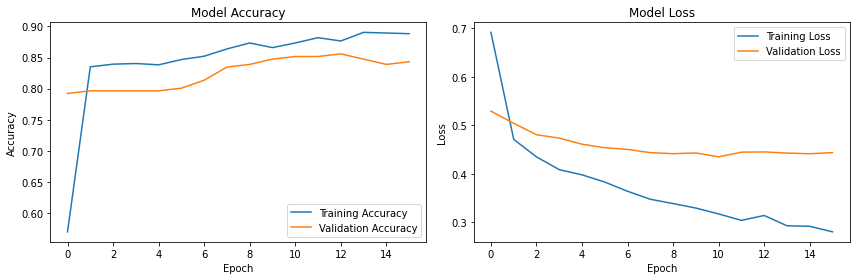

In [ ]:
# Visualize training history
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Prediction

In [22]:
import pandas as pd
import joblib
import tensorflow as tf
import numpy as np

# Define new data with the specified column order
new_data = {
    'Age': [33, 50, 28, 39, None],
    'DailyRate': [950, 1400, 1150, 800, 1300],
    'DistanceFromHome': [8, 15, 2, 20, 6],
    'EnvironmentSatisfaction': [3, 1, 4, 2, 3],
    'JobInvolvement': [2, 3, 4, 1, 3],
    'JobLevel': [1, 5, 2, 3, 2],
    'JobSatisfaction': [4, 2, 3, 1, 4],
    'MonthlyIncome': [3200, 11000, 4800, 7500, 4100],
    'StockOptionLevel': [0, 2, 1, 3, 1],
    'TotalWorkingYears': [5, 25, 3, 12, 7],
    'TrainingTimesLastYear': [2, 3, 1, 4, 2],
    'WorkLifeBalance': [2, 3, 3, 4, 1],
    'YearsAtCompany': [3, 20, 2, 8, 5],
    'YearsInCurrentRole': [2, 15, 1, 5, 3],
    'YearsWithCurrManager': [1, 10, 1, 4, 2],
    'BusinessTravel': ['Travel_Frequently', 'Travel_Rarely', np.nan, 'Non-Travel', 'Travel_Rarely'],
    'Department': ['Research & Development', 'Sales', 'Sales', 'Human Resources', 'Research & Development'],
    'EducationField': ['Technical Degree', 'Marketing', 'Life Sciences', 'Human Resources', 'Medical'],
    'JobRole': ['Sales Executive', 'Research Scientist', 'Human Resources', 'Manager', 'Laboratory Technician'],
    'MaritalStatus': ['Married', 'Divorced', 'Single', 'Married', 'Single'],
    'OverTime': ['No', 'Yes', 'No', 'Yes', 'No']
}

# Create a DataFrame from the dictionary
new_df = pd.DataFrame(new_data)

# Load the preprocessing pipeline
preprocessor = joblib.load('preprocess_pipeline.pkl')

# Preprocess the new data
new_data_preprocessed = preprocessor.transform(new_df)

# Load the trained model
model = tf.keras.models.load_model('ann_model.h5')

# Make predictions
y_pred_proba = model.predict(new_data_preprocessed)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()  # Convert probabilities to binary (0 or 1)

# Map predictions to 'No' or 'Yes'
attrition_labels = ['No', 'Yes']
predicted_attrition = [attrition_labels[pred] for pred in y_pred]

# Print the predictions
print("\n=== Predictions for New Employees ===")
for i, pred in enumerate(predicted_attrition):
    print(f"Employee {i+1}: Predicted Attrition = {pred}")

# Optional: Save predictions to a CSV file
new_df_with_predictions = new_df.copy()
new_df_with_predictions['Predicted_Attrition'] = predicted_attrition
new_df_with_predictions.to_csv('new_predictions.csv', index=False)
print("\nPredictions saved to 'new_predictions.csv'")


=== Predictions for New Employees ===
Employee 1: Predicted Attrition = No
Employee 2: Predicted Attrition = No
Employee 3: Predicted Attrition = No
Employee 4: Predicted Attrition = No
Employee 5: Predicted Attrition = No

Predictions saved to 'new_predictions.csv'
